In [1]:
!pip install pandas matplotlib seaborn missingno statsmodels prophet --upgrade
!pip install numpy==1.23.5 scipy==1.9.3 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 97.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 2.2 MB/s eta 0:00:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import joblib

In [2]:
data = pd.read_csv('/content/seattle_weather_1948-2017.csv')

In [3]:
print("Dataset Info:")
data.info()

print("\nFirst 5 rows:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25551 entries, 0 to 25550
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    25551 non-null  object 
 1   PRCP    25548 non-null  float64
 2   TMAX    25551 non-null  int64  
 3   TMIN    25551 non-null  int64  
 4   RAIN    25548 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 998.2+ KB

First 5 rows:
         DATE  PRCP  TMAX  TMIN  RAIN
0  1948-01-01  0.47    51    42  True
1  1948-01-02  0.59    45    36  True
2  1948-01-03  0.42    45    35  True
3  1948-01-04  0.31    45    34  True
4  1948-01-05  0.17    45    32  True


In [4]:
# Handle missing values
print("\nHandling Missing Values...")
data.fillna(method='ffill', inplace=True)

# Convert 'DATE' column to datetime and set as index
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# Normalize numerical features
print("\nNormalizing Numerical Features...")
scaler = MinMaxScaler()
numeric_features = ['PRCP', 'TMAX', 'TMIN']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Save the processed data
data.to_csv("processed_seattle_weather.csv", index=True)
print("\nProcessed data saved as 'processed_seattle_weather.csv'.")


Handling Missing Values...

Normalizing Numerical Features...


<ipython-input-4-ac90da696133>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-4-ac90da696133>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(method='ffill', inplace=True)



Processed data saved as 'processed_seattle_weather.csv'.



Fitting ARIMA Model...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Generating ARIMA Forecast...

ARIMA model saved as 'arima_seattle_weather_model.pkl'.


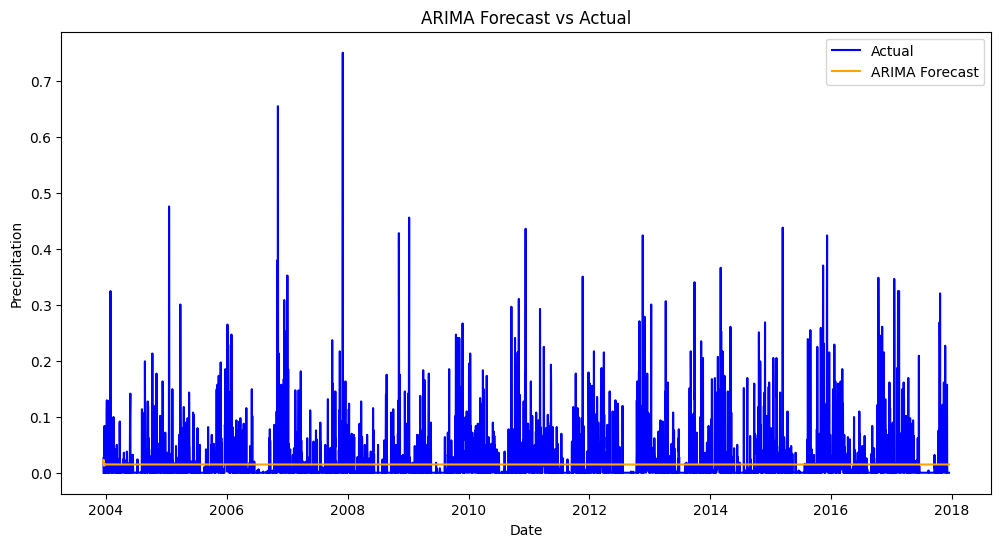

In [5]:
# Prepare data for ARIMA
data_forecasting = data['PRCP'].copy()

# Train-test split
train_size = int(len(data_forecasting) * 0.8)
train_data, test_data = data_forecasting[:train_size], data_forecasting[train_size:]

# Fit ARIMA model
print("\nFitting ARIMA Model...")
arima_model = ARIMA(train_data, order=(5, 1, 0))
arima_result = arima_model.fit()

# Forecast
print("\nGenerating ARIMA Forecast...")
arima_forecast = arima_result.forecast(steps=len(test_data))

# Save the ARIMA model
joblib.dump(arima_result, "arima_seattle_weather_model.pkl")
print("\nARIMA model saved as 'arima_seattle_weather_model.pkl'.")

# Plot ARIMA results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label="Actual", color="blue")
plt.plot(test_data.index, arima_forecast, label="ARIMA Forecast", color="orange")
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend()
plt.show()


Fitting Prophet Model...


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbdfoaz88/uz_fnunh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbdfoaz88/eqck30ao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94321', 'data', 'file=/tmp/tmpbdfoaz88/uz_fnunh.json', 'init=/tmp/tmpbdfoaz88/eqck30ao.json', 'output', 'file=/tmp/tmpbdfoaz88/prophet_modelyw0joxo3/prophet_model-20241117080245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:02:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:02:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet model saved as 'prophet_seattle_weather_model.pkl'.


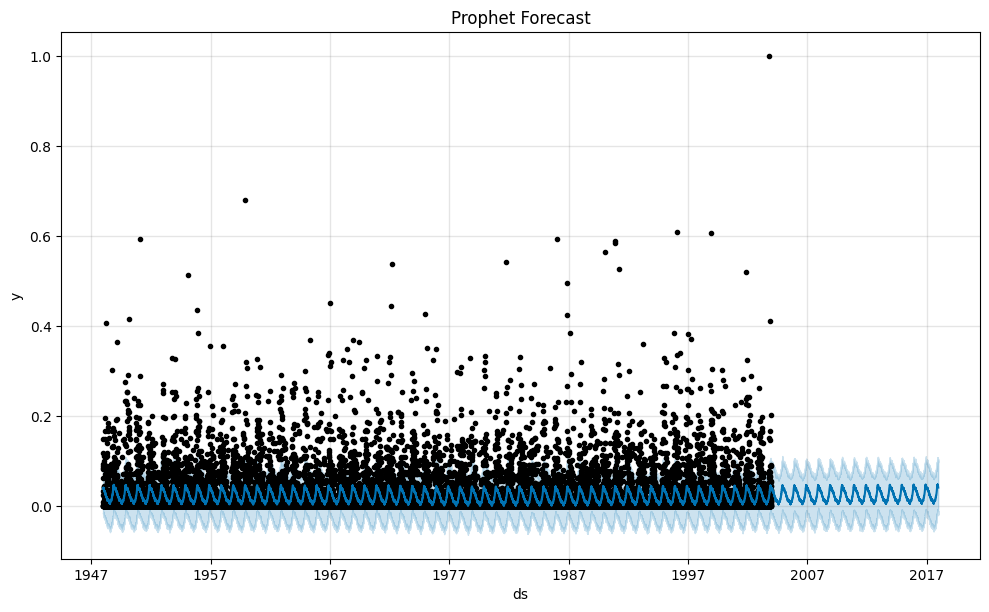

In [6]:
# Prepare data for Prophet
print("\nFitting Prophet Model...")
prophet_data = data_forecasting.reset_index().rename(columns={'DATE': 'ds', 'PRCP': 'y'})
train_prophet, test_prophet = prophet_data[:train_size], prophet_data[train_size:]

prophet_model = Prophet()
prophet_model.fit(train_prophet)

future = prophet_model.make_future_dataframe(periods=len(test_prophet))
forecast = prophet_model.predict(future)

# Save the Prophet model
joblib.dump(prophet_model, "prophet_seattle_weather_model.pkl")
print("\nProphet model saved as 'prophet_seattle_weather_model.pkl'.")

# Plot Prophet results
prophet_model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

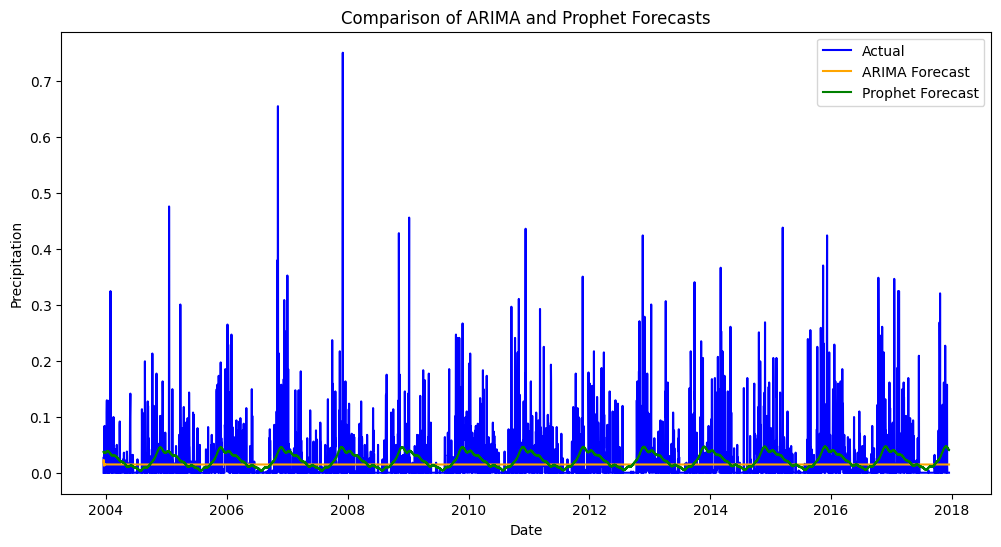

In [8]:
# Filter the forecast to match the test period
prophet_forecast_test = forecast.loc[forecast['ds'].isin(test_prophet['ds'])]

# Plot the comparison
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label="Actual", color="blue")
plt.plot(test_data.index, arima_forecast, label="ARIMA Forecast", color="orange")
plt.plot(prophet_forecast_test['ds'], prophet_forecast_test['yhat'], label="Prophet Forecast", color="green")
plt.title("Comparison of ARIMA and Prophet Forecasts")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend()
plt.show()
